### We combine the `nsa_z001_002` and `nsa_z002_004` UDG sample. Then we select those biggest and brightest galaxies.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [8]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

import pickle

In [9]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [199]:
udg_cat = vstack([Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z002_004/udg_z002_004_spergel_after_viz.fits'),
                  Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_002/udg_z001_002_spergel_after_viz.fits')])
# SB_avg_g-band > 24.3

In [200]:
# SB and R_e
SB_g_meas = udg_cat['SB_eff_avg'][:, 0].data
R_e = udg_cat['rhalf_spergel'].data * 0.168

# Correct for the measurement error
with open('./Catalog/completeness/Re_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
R_e += f_med(SB_g_meas)
R_e_std = f_std(SB_g_meas)

ang_diam_dist = udg_cat['host_ang_diam_dist'].data # not consider peculiar motion
R_e_phys = R_e / 206265 * ang_diam_dist * 1000 # in kpc
R_e_phys_std = R_e_std / 206265 * ang_diam_dist * 1000 # in kpc

with open('./Catalog/completeness/SB_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)

SB_g = SB_g_meas + f_med(SB_g_meas)
SB_g_std = f_std(SB_g_meas)

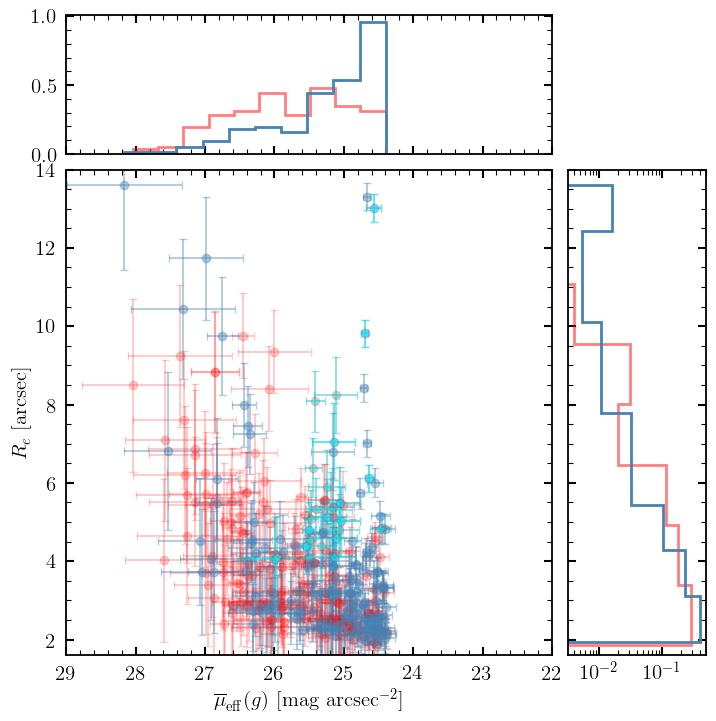

In [15]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2]) > 0.8)

ax.errorbar(SB_g[red], 
            R_e[red], 
            xerr=SB_g_std[red], yerr=R_e_std[red],
            fmt='o', color='r', alpha=0.2)

ax.errorbar(SB_g[~red], 
            R_e[~red], 
            xerr=SB_g_std[~red], yerr=R_e_std[~red],
            fmt='o', color='steelblue', alpha=0.4)

ax.errorbar(SB_g[flag], 
            R_e[flag], 
            xerr=SB_g_std[flag], yerr=R_e_std[flag],
            fmt='*', color='cyan', alpha=0.4)

ax.set_xlim(29, 22)
ax.set_ylim(1.6, 14)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(SB_g[red], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(SB_g[~red], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(R_e[red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(R_e[~red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')

In [201]:
flag = (((SB_g + SB_g_std) < 25.5) | (((SB_g - SB_g_std) < 25.5))) & (((R_e + R_e_std) > 5) | ((R_e - R_e_std) > 5))
flag = flag & (((udg_cat['ra'] < 75) | (udg_cat['ra'] > 315)) & (udg_cat['dec'] < 30))

# flag = (((SB_g + SB_g_std) < 25) | (((SB_g - SB_g_std) < 25))) & (((R_e + R_e_std) > 5) | ((R_e - R_e_std) > 5))
# flag = flag & (((udg_cat['ra'] < 75) | (udg_cat['ra'] > 315)) & (udg_cat['dec'] < 30))

In [202]:
np.sum(flag)

24

In [203]:
cat = udg_cat[flag]

# Check repeatance
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')

dist_mat = lsbg_coord[None, :].separation(lsbg_coord[:, None]).to(u.deg).value
np.fill_diagonal(dist_mat, 100)

if (dist_mat < (2 * u.arcsec).to(u.deg).value).sum() > 0:
    print('Have overlapping objects')
else:
    print('No overlapping objects')

No overlapping objects


In [280]:
## Visual inspect

In [204]:
# distance to host
lsbg_coord = SkyCoord(cat['ra'], cat['dec'], unit='deg')
host_coord = SkyCoord(cat['host_RA'], cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord).to(u.deg).value
dist_vir = dist / cat['host_r_vir_ang'].data

cat['dist_to_host_rvir'] = dist_vir

In [205]:
# cat.sort(keys='dist_to_host_rvir')
cat.sort(keys='SB_eff_avg_g')

In [206]:
# Visual inspection for their hosts!!

# cat[['viz-id', 'host_RA', 'host_DEC']].write(
#     '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_hosts.txt', 
#     format='ascii')
# Then visual inspection
host_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_hosts_spirals.txt', 
                      format='ascii')
cat['host_spiral'] = (host_cat['marked'] == 'true').astype(int)

In [207]:
hstack([cat[['viz-id', 'ra', 'dec']], 
        Column(data=np.round(cat['rhalf_spergel'] * 0.168, 2), name='rhalf_spergel_arcsec'),
        Column(data=np.round(cat['SB_eff_avg'][:, 0], 2), name='SB_eff_avg_g'), 
        Column(data=np.round(cat['mag'][:, 0] - cat['mag'][:, 2], 2), name='g-i'),
        Column(data=np.round(cat['host_z'], 4), name='host_z'),
        Column(data=np.round(cat['dist_to_host_rvir'], 2), name='dist2host_rvir'),
        cat[['host_spiral']]],
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_bright_large.txt', 
    format='ascii')

In [240]:
_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_sample_selected.txt', 
                 format='ascii')
selected_id = _cat[_cat['marked'] == 'true']['viz-id'].data

In [241]:
selected_cat = cat[np.in1d(cat['viz-id'].data, selected_id)]

In [242]:
# SB and R_e
SB_g_meas = selected_cat['SB_eff_avg_g'].data
R_e = selected_cat['rhalf_spergel'].data * 0.168

# Correct for the measurement error
with open('./Catalog/completeness/Re_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)
# R_e += f_med(SB_g_meas)
R_e_std = f_std(SB_g_meas)

ang_diam_dist = selected_cat['host_ang_diam_dist'].data # not consider peculiar motion
R_e_phys = R_e / 206265 * ang_diam_dist * 1000 # in kpc
R_e_phys_std = R_e_std / 206265 * ang_diam_dist * 1000 # in kpc

with open('./Catalog/completeness/SB_meas_err.pkl', 'rb') as f:
    (f_med, f_std) = pickle.load(f)

SB_g = SB_g_meas# + f_med(SB_g_meas)
SB_g_std = f_std(SB_g_meas)

red = ((selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2]) > 0.7)

In [243]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

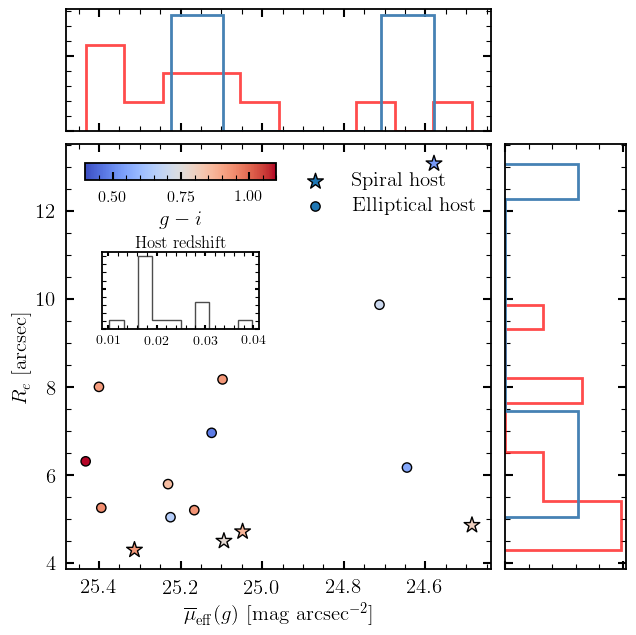

In [245]:
# start with a square Figure
fig = plt.figure(figsize=(7, 7))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.set_yticklabels([])
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_xticklabels([])

flag = (selected_cat['host_spiral'] == 1)
sct = ax.scatter(
    SB_g[flag],
    R_e[flag],
    c=(selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2])[flag],
    vmin=0.4, vmax=1.1,
    cmap='coolwarm',
    marker='*',
    edgecolor='k',
    s=140,
    alpha=1,
    label='Spiral host'
    )

sct = ax.scatter(
    SB_g[~flag],
    R_e[~flag],
    c=(selected_cat['mag'][:, 0] - selected_cat['mag'][:, 2])[~flag],
    vmin=0.4, vmax=1.1,
    cmap='coolwarm',
    edgecolor='k',
    s=45,
    alpha=1,
    label='Elliptical host'
    )

ax.legend(loc='upper right', bbox_to_anchor=(1.03, 1))

cax = inset_axes(ax, width="45%", height="4%", 
                 loc='upper left', bbox_to_anchor=(0.02, -0.02, 1, 1),
                 bbox_transform=ax.transAxes) 
plt.colorbar(sct, cax=cax, label='$g-i$',
             orientation='horizontal')
cax.tick_params(labelsize=11.5)

# ax.set_xlim(29, 24)
# ax.set_ylim(1.6, 14)
ax.invert_xaxis()
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$R_e\ [\rm arcsec]$')

ax_histx.hist(SB_g[red], lw=2,
              histtype='step', density=True, color='r', 
              alpha=0.7, label='$g-i > 0.7$')
ax_histx.hist(SB_g[~red], lw=2,
              histtype='step', density=True, color='steelblue', label='$g-i < 0.7$')
ax_histy.hist(R_e[red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.7)
ax_histy.hist(R_e[~red], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
# ax_histy.set_xscale('log')

# show redshift
cax2 = inset_axes(ax, width='37%', height='18%', 
                  loc='upper left', 
                  bbox_to_anchor=(0.06, -0.23, 1, 1),
                  bbox_transform=ax.transAxes)
cax2.hist(selected_cat['host_z'], histtype='step', density=True, color='k', alpha=0.7)
cax2.set_title('Host redshift', fontsize=12, pad=3)
cax2.set_yticklabels([])
cax2.set_xticks([0.01, 0.02, 0.03, 0.04])
cax2.tick_params(axis='both', which='both', length=3, labelsize=10, pad=4)

plt.savefig('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/sample_summary.png')

In [350]:
selected_cat['viz-id']

21450
27795
86113
67181
69381
65780
29808
79982
30269
14216
81835


##### Write to Tex

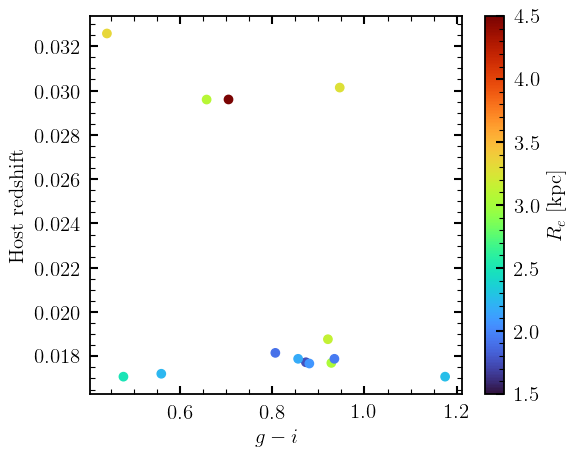

In [273]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_circularized_phys'], vmin=1.5, vmax=4.5)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [kpc]')

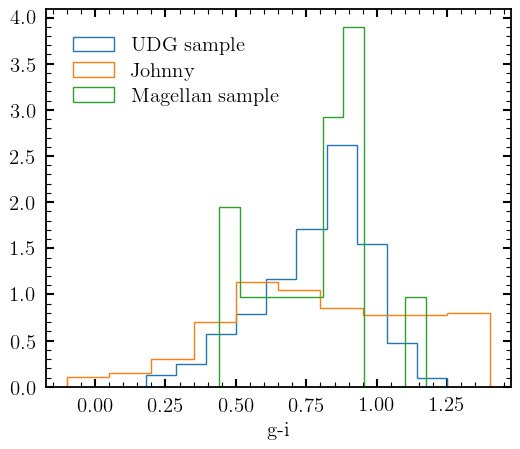

In [274]:
johnny = Table.read('./Catalog/Greco_S18A_lsbg.fits')
plt.hist(udg_cat['mag'][:, 0] - udg_cat['mag'][:, 2], histtype='step', density=True, label='UDG sample')
plt.hist(johnny['g-i'], histtype='step', density=True, label='Johnny')
plt.hist(cat['mag'][:, 0] - cat['mag'][:, 2], density=True, histtype='step', label='Magellan sample')
plt.xlabel('g-i')
plt.legend(loc='upper left')

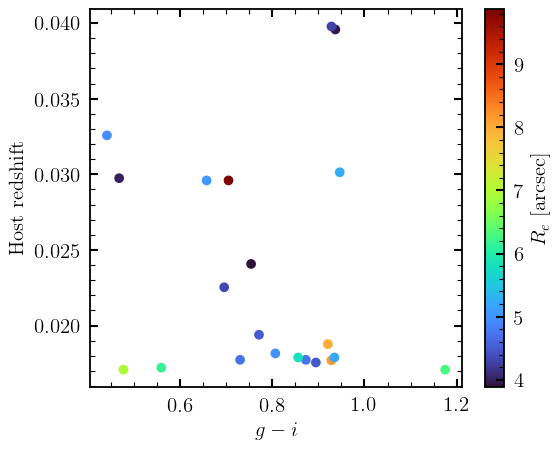

In [245]:
plt.scatter(cat['mag'][:, 0] - cat['mag'][:, 2], 
            cat['host_z'], 
            c=cat['rhalf_spergel'] * 0.168)
plt.xlabel('$g-i$')
plt.ylabel('Host redshift')
plt.colorbar(label='$R_e$ [arcsec]')

In [196]:
hstack([cat[['viz-id', 'ra', 'dec']], 
        Column(data=np.round(cat['rhalf_spergel'] * 0.168, 2), name='rhalf_'),
        Column(data=np.round(cat['SB_eff_avg'][:, 0], 2), name='SB_eff_avg_g'), 
        Column(data=np.round(cat['mag'][:, 0], 2), name='g_mag'),
        Column(data=np.round(cat['mag'][:, 0] - cat['mag'][:, 2], 2), name='g-i'),
       Column(data=np.round(cat['dist_to_host_rvir'], 2), name='dist2host_rvir')]
      ).write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_cat_latex.tex', 
    format='ascii.latex')

In [197]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [199]:
from astropy.coordinates import SkyCoord
from astroplan import FixedTarget
from astroplan import Observer
from astroplan.plots import plot_airmass 
observer = Observer.at_site('Las Campanas Observatory')

In [235]:
objs = []
for i in range(15):
    coord = SkyCoord(cat['ra'][i], cat['dec'][i], unit='deg')
#     obj = FixedTarget(name=str(cat['viz-id'][i]), coord=coord)
    obj = FixedTarget(name=None, coord=coord)
    objs.append(obj)

No handles with labels found to put in legend.


Text(0.5, 1.0, '2022-09-15 02:00:00.000')

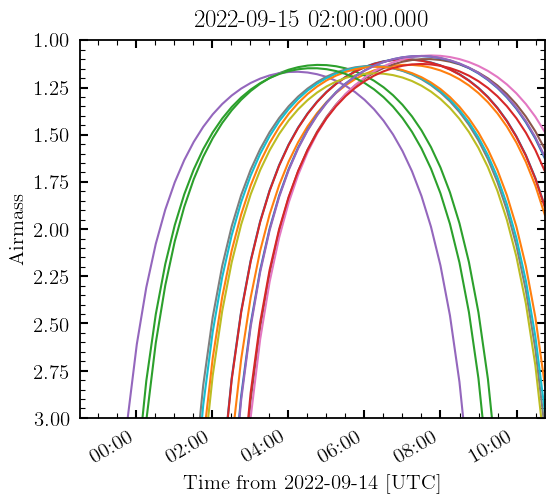

In [243]:
time = Time('2022-09-15 02:00')
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(15):
    plot_airmass(objs[i], observer, observe_time, )
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.legend(shadow=True, loc=2)
plt.title(time)

No handles with labels found to put in legend.


Text(0.5, 1.0, '2022-11-15 02:00:00.000')

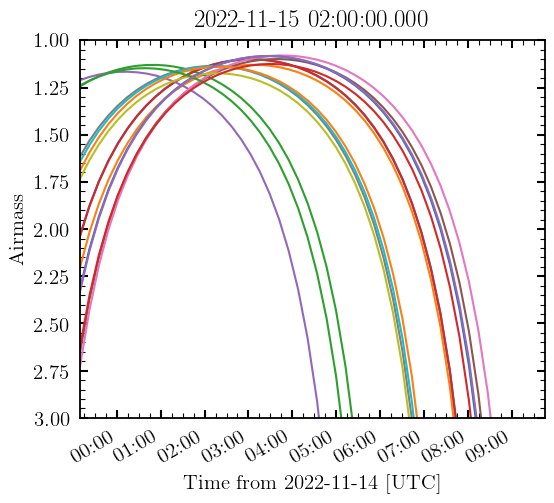

In [242]:
time = Time('2022-11-15 02:00')
sunset_time = observer.sun_set_time(time, which='nearest')
sunrise_time = observer.sun_rise_time(time, which='nearest')

observe_time = sunset_time + np.linspace(0, (sunrise_time - sunset_time).to(u.hour).value, 50) * u.hour

for i in range(15):
    plot_airmass(objs[i], observer, observe_time, )
# plot_airmass(objs[1], observer, observe_time)
# plot_airmass(objs[2], observer, observe_time)

plt.legend(shadow=True, loc=2)
plt.title(time)